## Case Study: Transforming Keypoints



In [1]:
#Setting up the data path 
import os 
os.environ['DALI_EXTRA_PATH']='../DALI_extra'

In [2]:
#importing the required libraries 
import nvidia.dali as dali
import nvidia.dali.fn as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import os

dali_extra_dir = os.environ["DALI_EXTRA_PATH"]
root_dir = os.path.join(dali_extra_dir, 'db', 'face_landmark')

# images are in JPEG format
image_files = ["{}.jpeg".format(i) for i in range(6)]
# keypoints are in NumPy files
keypoint_files = ["{}.npy".format(i) for i in range(6)]

In [3]:
# Creating a fucntion for visulaizing the results 
def show(images, landmarks):
    if hasattr(images, "as_cpu"):
        images = images.as_cpu()
    batch_size = len(images)

    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize = (16,14))
    plt.suptitle(None)
    columns = 3
    rows = int(math.ceil(batch_size / columns))
    gs = gridspec.GridSpec(rows, columns)
    for i in range(batch_size):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        plt.title('')
        img = images.at(i)
        r = 0.002 * max(img.shape[0], img.shape[1])
        for p in landmarks.at(i):
            circle = patches.Circle(p, r, color=(0,1,0,1))
            ax.add_patch(circle)
        plt.imshow(img)

First, let's build a pipeline that just loads the images and keypoints, without any augmentations:

In [4]:
#Building DATA loading Pipeline
pipe = dali.pipeline.Pipeline(6, 3, 0)
with pipe:
    jpegs, _ = fn.readers.file(file_root=root_dir, files=image_files)
    images = fn.decoders.image(jpegs, device="mixed")
    keypoints = fn.readers.numpy(file_root=root_dir, files=keypoint_files)
    pipe.set_outputs(images, keypoints)

In [5]:
#Running the pipeline
pipe.build()
images, keypoints = pipe.run()

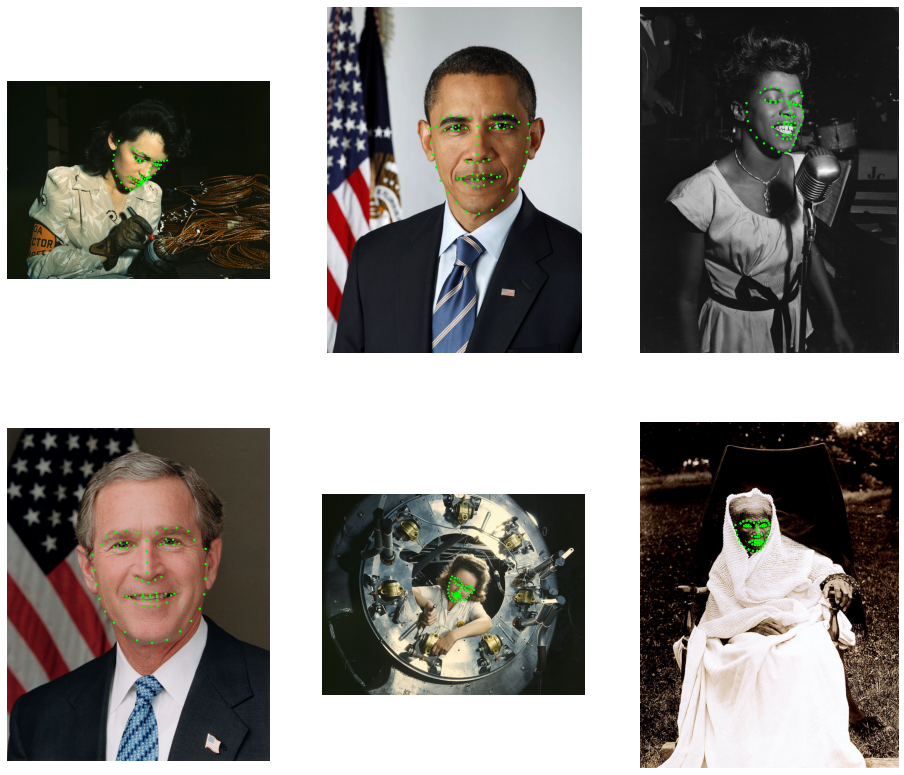

In [6]:
#Displaying the results 
show(images, keypoints)

## Adding Transforms to the Pipeline

In this step we apply a transform to the images and keypoints. We use `warp_affine` to transform images and `coord_transform` to transform keypoints.
The operator `warp_affine` uses the transform matrix to perform inverse mapping: destination pixel coordinates are mapped to source coordinates. This effectively transforms the locations of image features by the inverse of the transform matrix. To make the keypoints and images transformed in the same way, we need to specify `inverse_map=False` in warp_affine.

In [7]:
#Adding Transofrms to the pipeline
pipe = dali.pipeline.Pipeline(6, 3, 0, seed = 1234)
with pipe:
    jpegs, _ = fn.readers.file(file_root=root_dir, files=image_files)
    images = fn.decoders.image(jpegs, device="mixed")
    keypoints = fn.readers.numpy(file_root=root_dir, files=keypoint_files)
    mt = fn.transforms.rotation(angle = fn.random.uniform(range=(-45, 45)))
    #wrap transform is used to trasforms the images.
    images = fn.warp_affine(images, matrix = mt, fill_value=0, inverse_map=False)
    #coerd transform is used to trasforms the keypoints.
    keypoints = fn.coord_transform(keypoints, MT = mt)
    pipe.set_outputs(images, keypoints)
    
pipe.build()
images, keypoints = pipe.run()

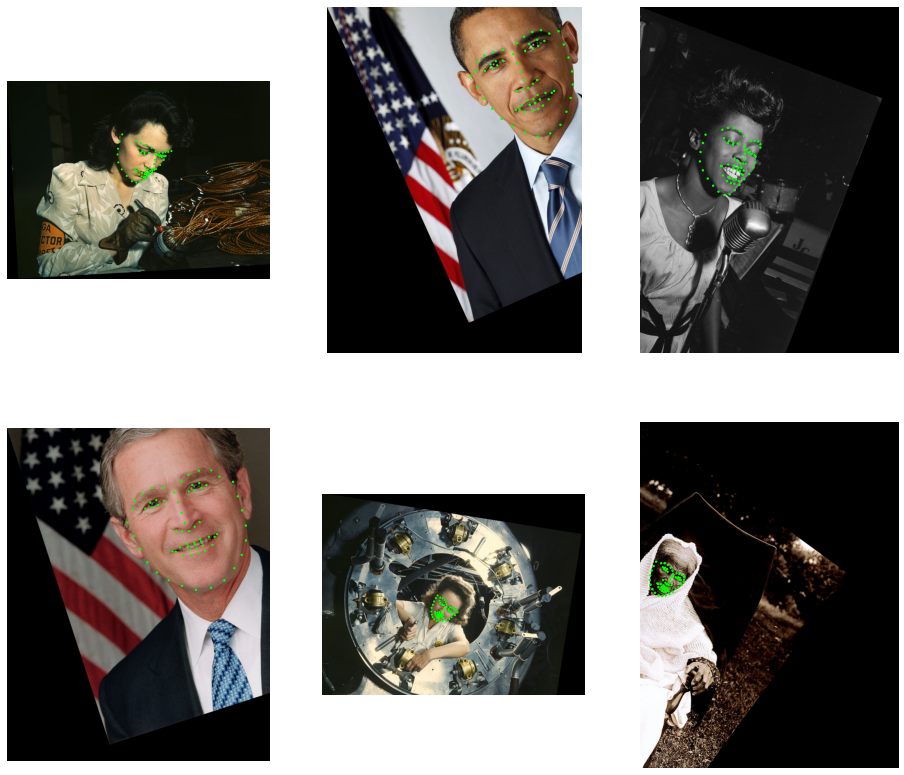

In [8]:
show(images, keypoints)

As we can see, the images have been rotated around point (0, 0) which is top-left corner.
To rotate around the center, we can pass additional `center` argument to rotate.
We can't use a shape of images to calculate the center, becuase the images are on GPU. We can, however, look up the image shapes before decoding with `peek_image_shape` operator.

In [9]:
def encoded_images_sizes(jpegs):
    shapes = fn.peek_image_shape(jpegs)  # the shapes are HWC
    h = fn.slice(shapes, 0, 1, axes=[0]) # extract height...
    w = fn.slice(shapes, 1, 1, axes=[0]) # ...and width...
    return fn.cat(w, h)                  # ...and concatenate

pipe = dali.pipeline.Pipeline(6, 3, 0, seed = 1234)
with pipe:
    jpegs, _ = fn.readers.file(file_root=root_dir, files=image_files)
    images = fn.decoders.image(jpegs, device="mixed")
    
    size = encoded_images_sizes(jpegs)
    center = size / 2
    
    keypoints = fn.readers.numpy(file_root=root_dir, files=keypoint_files)
    #for rotating the images from center we need to specify center
    mt = fn.transforms.rotation(angle = fn.random.uniform(range=(-45, 45)), center = center)
    images = fn.warp_affine(images, matrix = mt, fill_value=0, inverse_map=False)
    keypoints = fn.coord_transform(keypoints, MT = mt)
    pipe.set_outputs(images, keypoints)
    
pipe.build()
images, keypoints = pipe.run()

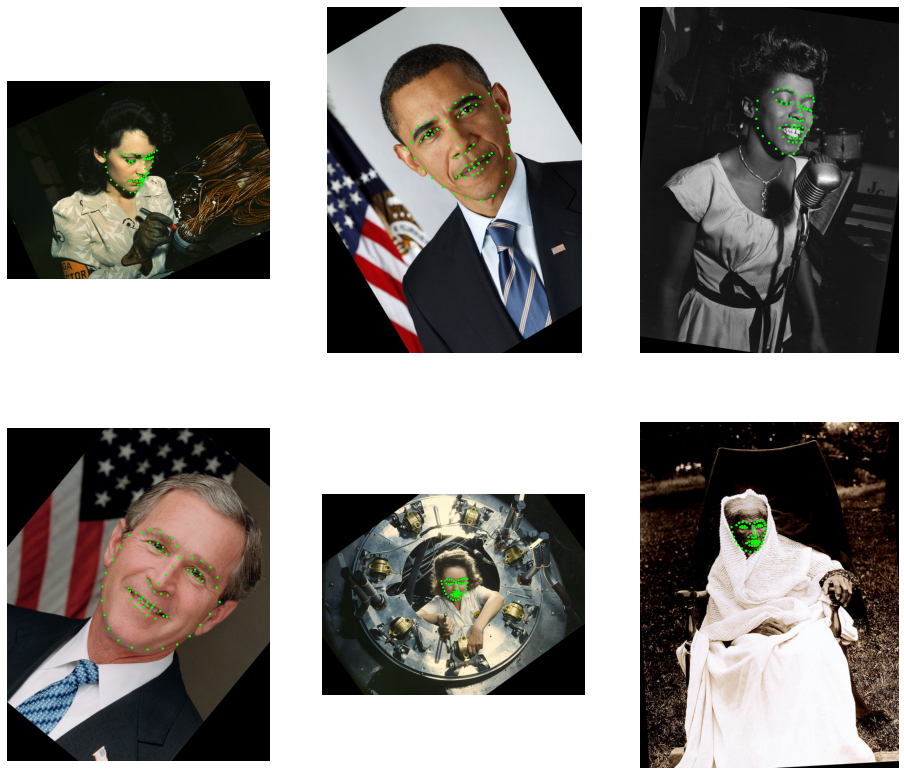

In [10]:
show(images, keypoints)

In [11]:
#Combining transformations
pipe = dali.pipeline.Pipeline(6, 3, 0, seed = 1234)
with pipe:
    jpegs, _ = fn.readers.file(file_root=root_dir, files=image_files)
    images = fn.decoders.image(jpegs, device="mixed")
    
    size = encoded_images_sizes(jpegs)
    center = size / 2
    
    keypoints = fn.readers.numpy(file_root=root_dir, files=keypoint_files)
    mt = fn.transforms.rotation(angle = fn.random.uniform(range=(-45, 45)), center = center)
    mt = fn.transforms.translation(mt, offset = (400,0))
    images = fn.warp_affine(images, matrix = mt, fill_value=0, inverse_map=False)
    keypoints = fn.coord_transform(keypoints, MT = mt)
    pipe.set_outputs(images, keypoints)
    
pipe.build()
images, keypoints = pipe.run()

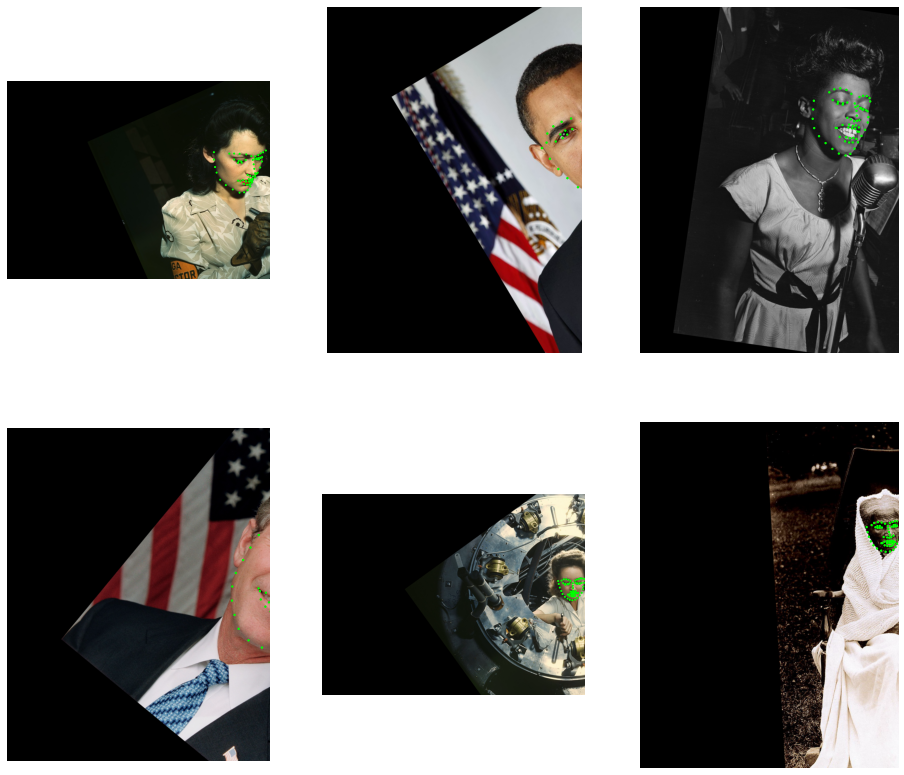

In [12]:
show(images, keypoints)

In [13]:
#Transformation by combining two matrices.
pipe = dali.pipeline.Pipeline(6, 3, 0, seed = 1234)
with pipe:
    jpegs, _ = fn.readers.file(file_root=root_dir, files=image_files)
    images = fn.decoders.image(jpegs, device="mixed")
    
    size = encoded_images_sizes(jpegs)
    center = size / 2
    
    keypoints = fn.readers.numpy(file_root=root_dir, files=keypoint_files)
    tr1 = fn.transforms.translation(offset=-center)
    tr2 = fn.transforms.translation(offset=center)
    rot = fn.transforms.rotation(angle = fn.random.uniform(range=(-45, 45)))
    mt = fn.transforms.combine(tr1, rot, np.float32([[1, 1, 0],
                                               [0, 1, 0]]), tr2)
    images = fn.warp_affine(images, matrix = mt, fill_value=0, inverse_map=False)
    keypoints = fn.coord_transform(keypoints, MT = mt)
    pipe.set_outputs(images, keypoints)
    
pipe.build()
images, keypoints = pipe.run()

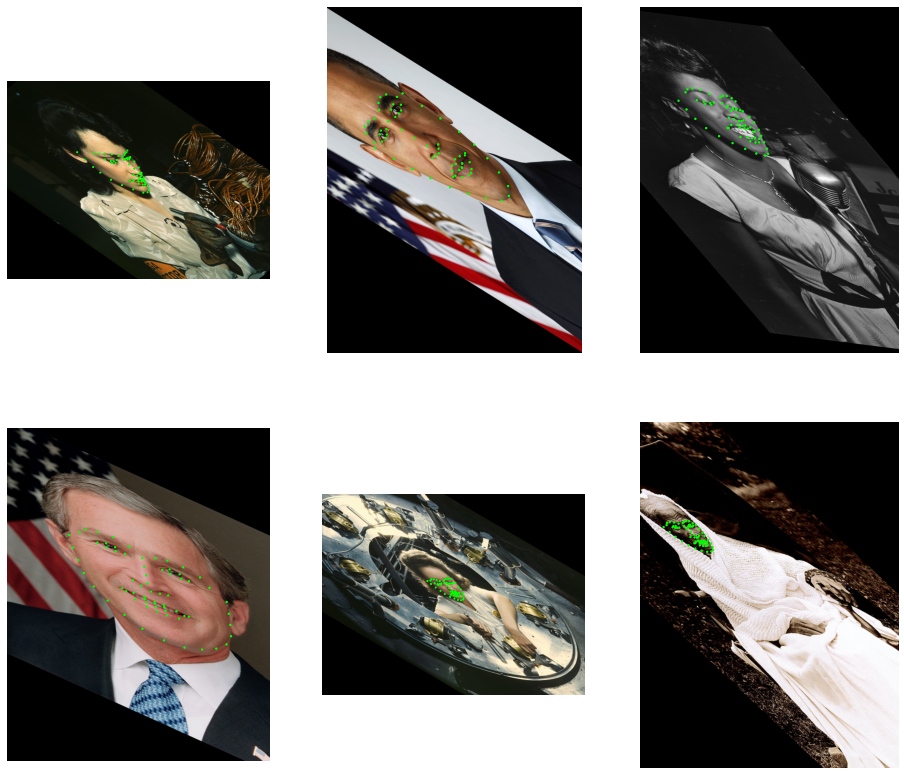

In [14]:
show(images, keypoints)

## Keypoint Cropping



In [15]:
pipe = dali.pipeline.Pipeline(6, 3, 0, seed = 1234)
with pipe:
    jpegs, _ = fn.readers.file(file_root=root_dir, files=image_files)
    images = fn.decoders.image(jpegs, device="mixed")
    keypoints = fn.readers.numpy(file_root=root_dir, files=keypoint_files)
    
    # This part defines the agumentations: shear + rotation
    mt = fn.transforms.shear(shear = fn.random.uniform(range=(-1, 1), shape=[2]))
    mt = fn.transforms.rotation(mt, angle = fn.random.uniform(range=(-45, 45)))
    
    # Now, let's see where the keypoints would be after applying this transform
    uncropped = fn.coord_transform(keypoints, MT = mt)
    
    # Find the bounding box of the keypoints
    lo = fn.reductions.min(uncropped, axes=[0])
    hi = fn.reductions.max(uncropped, axes=[0])
    # ...and get its larger extent (width or height)
    size = fn.reductions.max(hi - lo)
    center = (lo + hi) / 2
    # make a square region centered at the center of the bounding box
    lo = center - size  # full size - this adds 50% margin
    hi = center + size  # likewise
    
    # Now we can calculate a crop transform that will map the bounding box to a 400x400 window
    # and combine it with the previous transform.
    mt = fn.transforms.crop(mt, from_start = lo, from_end = hi, to_start = [0,0], to_end=[400, 400])
    
    # Apply the transform to the keypoints; specify the output size of 400x400.
    images = fn.warp_affine(images, size=[400, 400], matrix = mt, fill_value=0, inverse_map=False)
    keypoints = fn.coord_transform(keypoints, MT = mt)
    pipe.set_outputs(images, keypoints)
    
pipe.build()
images, keypoints = pipe.run()

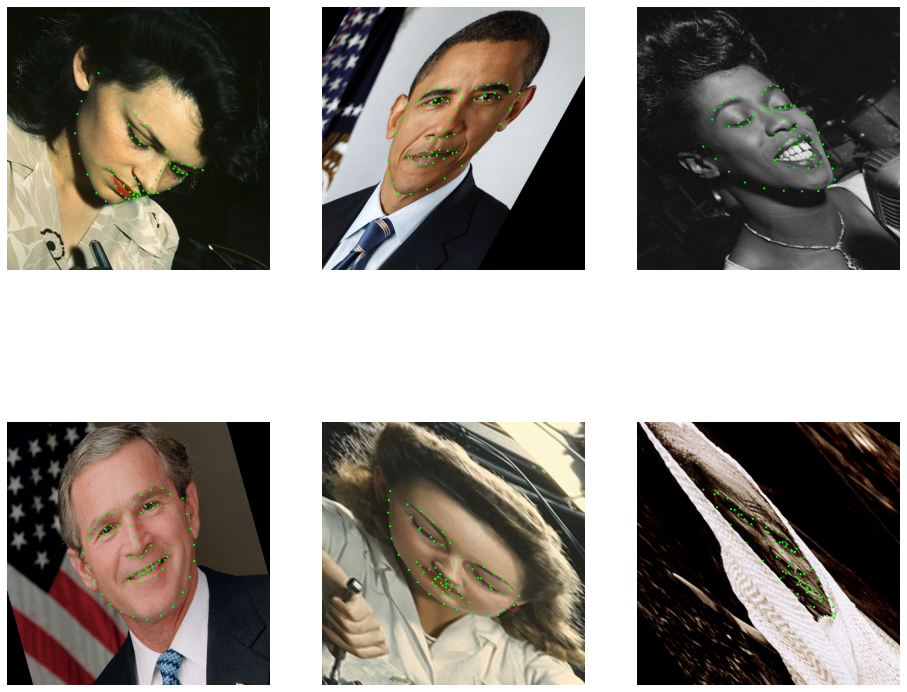

In [16]:
show(images, keypoints)

## Transform Gallery

This section demonstrates each of the transforms applied to all of the example images.

In [17]:
pipe = dali.pipeline.Pipeline(6, 3, 0, seed = 1234)
with pipe:
    jpegs, _ = fn.readers.file(file_root=root_dir, files=image_files)
    images = fn.decoders.image(jpegs, device="mixed")
    keypoints = fn.readers.numpy(file_root=root_dir, files=keypoint_files)
    
    size = encoded_images_sizes(jpegs)
    center = size / 2
    
    outputs = []
    
    transforms = [
        fn.transforms.translation(offset = fn.random.uniform(range=(-100, 100), shape = 2)),
        fn.transforms.rotation(angle = fn.random.uniform(range=(-45, 45)), center = center),
        fn.transforms.scale(scale = fn.random.uniform(range=(0.5, 2), shape=[2]), center = center),
        fn.transforms.shear(shear = fn.random.uniform(range=(-1, 1), shape=[2]), center = center),
        fn.transforms.crop(from_start = size * 0.1, from_end = size * 0.8, to_start = [0,0], to_end=size*1.0)
    ]

    for mt in transforms:
        out_img = fn.warp_affine(images, matrix = mt, fill_value=0, inverse_map=False)
        out_kp = fn.coord_transform(keypoints, MT = mt)
        outputs += [out_img, out_kp]
    pipe.set_outputs(*outputs)
    
pipe.build()
pipe_out = pipe.run()

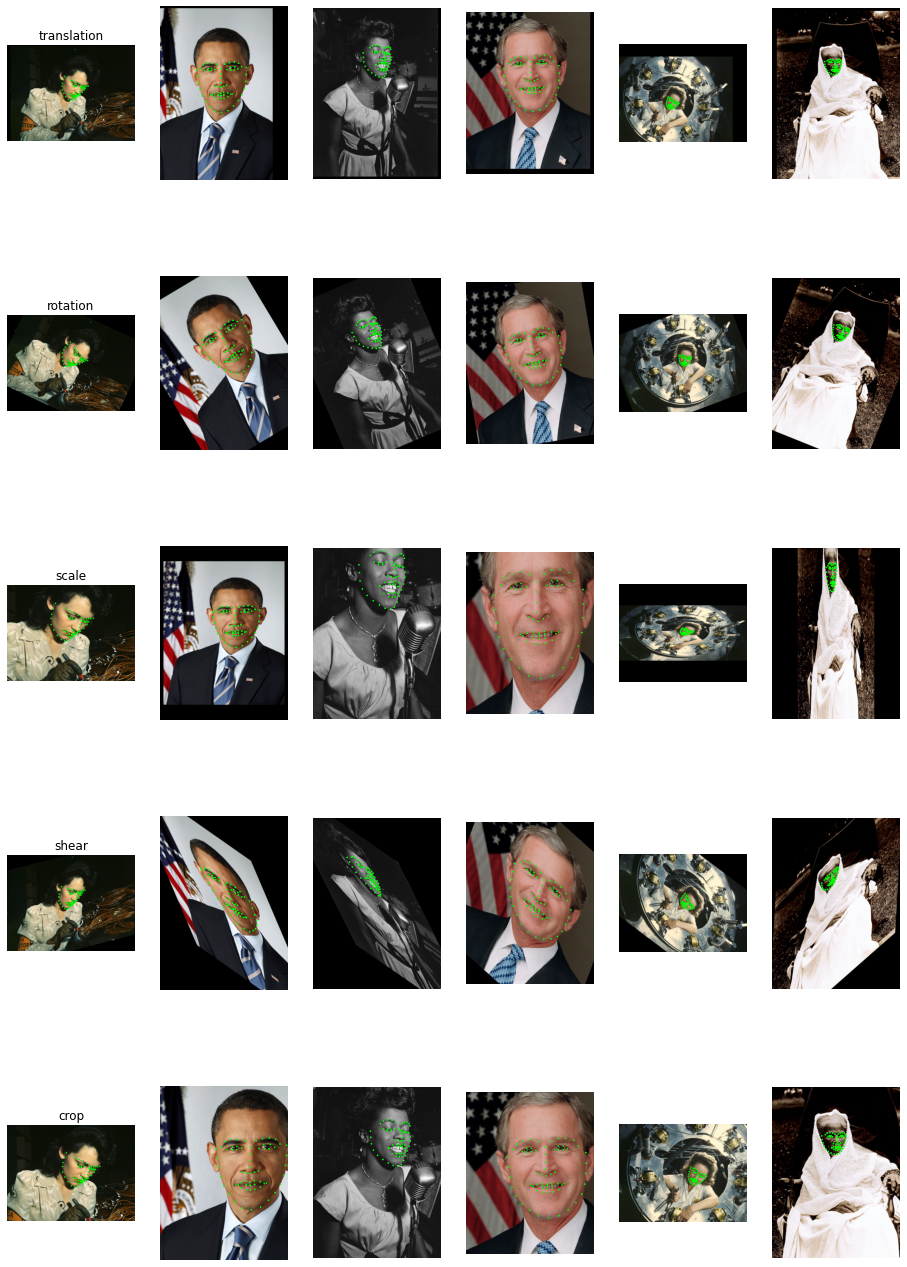

In [18]:
def gallery(pipe_out, titles):
    pipe_out = [x.as_cpu() if hasattr(x, "as_cpu") else x for x in pipe_out]
    
    batch_size = len(pipe_out[0])

    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize = (16,24))
    plt.suptitle(None)
    columns = batch_size
    rows = len(pipe_out) // 2
    gs = gridspec.GridSpec(rows, columns)
    flat = 0
    for j in range(0, len(pipe_out), 2):
        for i in range(batch_size):
            ax = plt.subplot(gs[flat])
            plt.axis("off")
            plt.title('')
            img = pipe_out[j].at(i)
            r = 0.002 * max(img.shape[0], img.shape[1])
            for p in pipe_out[j+1].at(i):
                circle = patches.Circle(p, r, color=(0,1,0,1))
                ax.add_patch(circle)
            plt.imshow(img)
            if i == 0:
                plt.title(titles[j // 2])
            flat += 1
            
gallery(pipe_out, ["translation", "rotation", "scale", "shear", "crop"])